In [1]:
import numpy as np
import tensorflow as tf

from craynn import *
from crayopt import *

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
def get_data(r_min, r_max, size=128):
    angles_pos = np.random.uniform(0, 2 * np.pi, size=(size, ))
    r_pos = np.random.uniform(r_min, r_max, size=(size, ))
    
    return np.stack([
        np.sin(angles_pos) * r_pos,
        np.cos(angles_pos) * r_pos,
    ], axis=1)

In [3]:
data_test = tf.Variable(get_data(0, 1), dtype=tf.float32)
data_pos = tf.Variable(get_data(1, 2), dtype=tf.float32)
data_neg = tf.Variable(get_data(2, 4), dtype=tf.float32)

## Data

The normal class is distributed within a 'doughnut':
$$X = (R \cdot \cos \Phi, R \cdot \sin \Phi)$$
where:
- $R \sim U[1, 2]$;
- $\Phi \sim U[0, 2 \pi]$.

Anomalies are distributed everywhere else ($R \leq 4$), however, anomalious instances only with $\|X\| > 2$ are available (one can either assume that negative sample is non-representative or consider higher dimensions where such situation can easily happen by pure chance).

We take a relatively large negative sample to avoid unnecessary stochasticity in the solution.

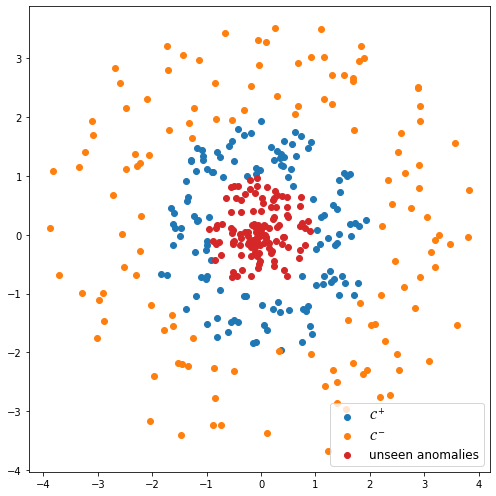

In [4]:
plt.figure(figsize=(7, 7))
plt.scatter(data_pos[:, 0], data_pos[:, 1], color=plt.cm.tab10(0), label='$\mathcal{C}^+$')
plt.scatter(data_neg[:, 0], data_neg[:, 1], color=plt.cm.tab10(1), label='$\mathcal{C}^-$')
plt.scatter(data_test[:, 0], data_test[:, 1], color=plt.cm.tab10(3), label='unseen anomalies')
plt.legend(fontsize=12, loc='lower right')
plt.tight_layout()
plt.savefig('imgs/metric-learning-data.png', dpi=200)

# Triplet loss

We use $\mathbb{R}^2 \to \mathbb{R}^2$ embedding. It is unclear how to select an anchor, here we just select a random positive samples. Using a constant anchor or a uniformly drawn subset of positive samples leads to the same results.

In [5]:
embedding = network((None, 2))(
    dense(64, activation=elu()),
    dense(32, activation=elu()),
    dense(2, activation=linear())
)

In [6]:
optimizer_embedding = tf_updates.adam(learning_rate=1e-3)(embedding.variables(trainable=True))

In [7]:
rng1 = tf.random.Generator.from_seed(seed=111)
rng2 = tf.random.Generator.from_seed(seed=112)
rng3 = tf.random.Generator.from_seed(seed=114)

alpha = tf.constant(0.1, dtype=tf.float32)
zero = tf.constant(0.0, dtype=tf.float32)

@tf.function(autograph=False)
def step():
    indx1 = rng1.uniform(shape=(8,), minval=0, maxval=data_pos.shape[0], dtype=tf.int64)
    X_anchor = tf.gather(data_pos, indx1)

    indx2 = rng2.uniform(shape=(8,), minval=0, maxval=data_pos.shape[0], dtype=tf.int64)
    X_pos = tf.gather(data_pos, indx2)

    indx3 = rng3.uniform(shape=(8,), minval=0, maxval=data_neg.shape[0], dtype=tf.int64)
    X_neg = tf.gather(data_neg, indx3)
    
    with optimizer_embedding:
        emb_anchor = embedding(X_anchor)
        emb_pos = embedding(X_pos)
        emb_neg = embedding(X_neg)
        
        d_anchor_pos = tf.reduce_sum(tf.square(emb_anchor - emb_pos), axis=1)
        d_anchor_neg = tf.reduce_sum(tf.square(emb_anchor - emb_neg), axis=1)
        
        loss = tf.maximum(
            zero,
            d_anchor_pos - d_anchor_neg + alpha
        )
        
        return optimizer_embedding(tf.reduce_mean(loss))

In [8]:
losses = train.iterate(step, 2048, 64, progress=tqdm)

Text(0, 0.5, 'loss')

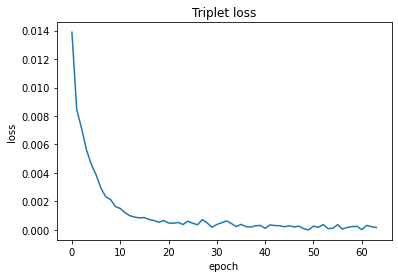

In [9]:
plt.title('Triplet loss')
plt.plot(np.mean(losses, axis=1))
plt.xlabel('epoch')
plt.ylabel('loss')

In [10]:
origins = tf.concat([data_pos, data_neg, data_test], axis=0)
embeddings = embedding(origins)
zero_shift = embedding(tf.zeros(shape=(1, 2), dtype=tf.float32))

deltas = embeddings - origins

### centering embeddings
deltas = deltas - zero_shift

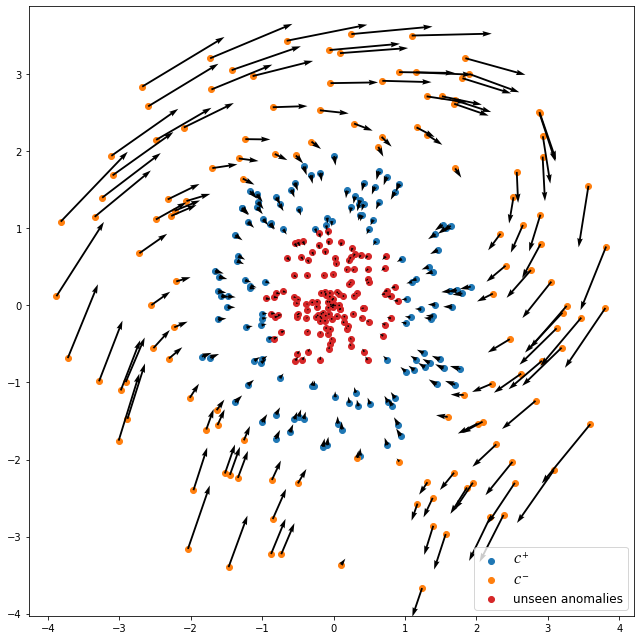

In [11]:
plt.figure(figsize=(9, 9))
plt.scatter(data_pos[:, 0], data_pos[:, 1], color=plt.cm.tab10(0), label='$\mathcal{C}^+$')
plt.scatter(data_neg[:, 0], data_neg[:, 1], color=plt.cm.tab10(1), label='$\mathcal{C}^-$')
plt.scatter(data_test[:, 0], data_test[:, 1], color=plt.cm.tab10(3), label='unseen anomalies')

plt.legend(fontsize=12, loc='lower right')

plt.quiver(origins[:, 0], origins[:, 1], deltas[:, 0], deltas[:, 1], angles='xy', units='xy')

plt.tight_layout()
plt.savefig('imgs/metric-learning-triplet.png', dpi=200)

In [12]:
xs, ys = np.linspace(-4, 4, num=20), np.linspace(-4, 4, num=20)
grid_x, grid_y = np.meshgrid(xs, ys)
flat_grid = np.stack([grid_x.ravel(), grid_y.ravel()], axis=1).astype('float32')

embeddings = embedding(flat_grid)
zero_shift = embedding(tf.zeros(shape=(1, 2), dtype=tf.float32))

deltas = embeddings - flat_grid

### centering embeddings
deltas = deltas - zero_shift

(-4.0, 4.0)

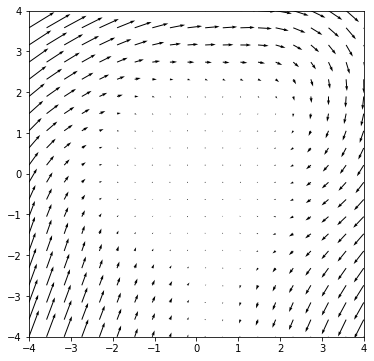

In [13]:
plt.figure(figsize=(6, 6))
plt.quiver(flat_grid[:, 0], flat_grid[:, 1], deltas[:, 0], deltas[:, 1], angles='xy', units='xy')
plt.xlim([-4, 4])
plt.ylim([-4, 4])

In [14]:
embeddings_pos = embedding(data_pos) - zero_shift
embeddings_neg = embedding(data_neg) - zero_shift
embeddings_test = embedding(data_test) - zero_shift

## Testing triplet loss on unseen anomalies
As can be seen from the embeddings, test anomalies ($R \leq 1$) are mapped inside the image of the positive class, making them indistinguishable from the normal samples.

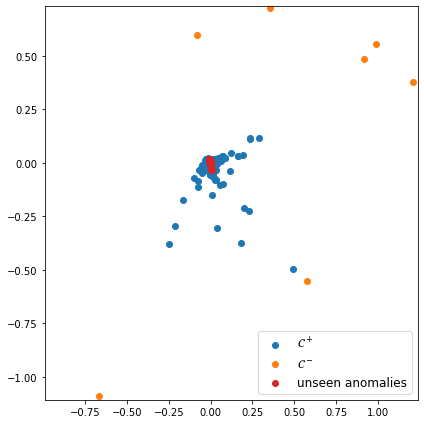

In [15]:
plt.figure(figsize=(6, 6))
plt.scatter(embeddings_pos[:, 0], embeddings_pos[:, 1], color=plt.cm.tab10(0), label='$\mathcal{C}^+$')
plt.scatter(embeddings_neg[:, 0], embeddings_neg[:, 1], color=plt.cm.tab10(1), label='$\mathcal{C}^-$')
plt.scatter(embeddings_test[:, 0], embeddings_test[:, 1], color=plt.cm.tab10(3), label='unseen anomalies')
plt.legend(fontsize=12, loc='lower right')

min_x, min_y = np.minimum(np.min(embeddings_pos, axis=0), np.min(embeddings_test, axis=0))
max_x, max_y = np.maximum(np.max(embeddings_pos, axis=0), np.max(embeddings_test, axis=0))
delta_x, delta_y = max_x - min_x, max_y - min_y

plt.xlim([min_x - delta_x, max_x + delta_x])
plt.ylim([min_y - delta_y, max_y + delta_y])

plt.tight_layout()
plt.savefig('imgs/metric-learning-embeddings.png', dpi=200)

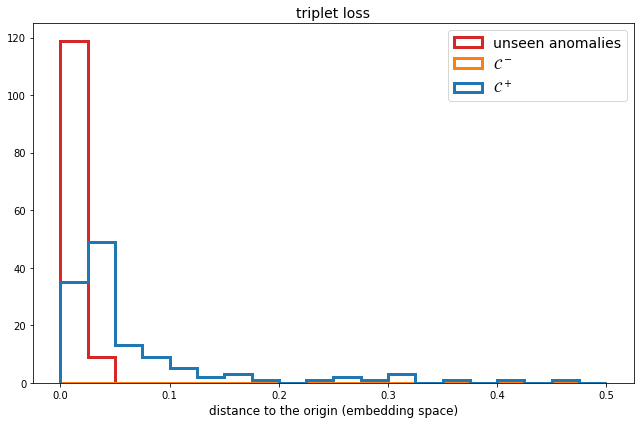

In [16]:
r_pos = np.sqrt(np.sum(np.square(embeddings_pos), axis=1))
r_neg = np.sqrt(np.sum(np.square(embeddings_neg), axis=1))
r_test = np.sqrt(np.sum(np.square(embeddings_test), axis=1))

plt.figure(figsize=(9, 6))
_ = plt.hist(
    [r_pos, r_neg, r_test],
    histtype='step', bins=20, range=(0, 0.5), lw=3,
    label=['$\mathcal{C}^+$', '$\mathcal{C}^-$', 'unseen anomalies'],
    color=[plt.cm.tab10(0), plt.cm.tab10(1), plt.cm.tab10(3)],
)
_ = plt.legend(loc='upper right', fontsize=14)
plt.xlabel('distance to the origin (embedding space)', fontsize=12)
plt.title('triplet loss', fontsize=14)

plt.tight_layout()
plt.savefig('imgs/metric-learning-distance-distribution.png', dpi=200)

## OPE

In [17]:
### the closest architecture to the embedding
clf = network((None, 2))(
    dense(64, activation=elu()),
    dense(32, activation=elu()),
    dense(1, activation=linear()),
    flatten(1)
)

In [18]:
optimizer_ope = tf_updates.adam(learning_rate=1e-3)(clf.variables(trainable=True))

In [19]:
rng1 = tf.random.Generator.from_seed(seed=111)
rng2 = tf.random.Generator.from_seed(seed=112)
rng3 = tf.random.Generator.from_seed(seed=113)

@tf.function(autograph=False)
def step_clf():
    indx_pos = rng1.uniform(shape=(8,), minval=0, maxval=data_pos.shape[0], dtype=tf.int64)
    X_pos = tf.gather(data_pos, indx_pos)

    indx_neg = rng2.uniform(shape=(8,), minval=0, maxval=data_neg.shape[0], dtype=tf.int64)
    X_neg = tf.gather(data_neg, indx_neg)
    
    X_gen = rng3.uniform(shape=(8, 2), minval=-4, maxval=4, dtype=tf.float32)
    
    with optimizer_ope:
        loss_pos = tf.reduce_mean(tf.nn.softplus(-clf(X_pos)))
        loss_neg = tf.reduce_mean(tf.nn.softplus(clf(X_neg)))
        loss_gen = tf.reduce_mean(tf.nn.softplus(clf(X_gen)))

        ### coefficients are arbitrary
        loss = 0.5 * loss_pos + 0.25 * loss_neg + 0.25 * loss_gen

        return optimizer_ope(loss)

In [20]:
losses = train.iterate(step_clf, 2048, 64, progress=tqdm)

Text(0, 0.5, 'loss')

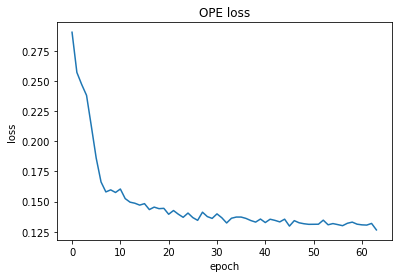

In [21]:
plt.title('OPE loss')
plt.plot(np.mean(losses, axis=1))
plt.xlabel('epoch')
plt.ylabel('loss')

In [22]:
xs = np.linspace(4, -4, num=21)
x_grid, y_grid = np.meshgrid(xs, xs)
X_grid = np.stack([
    x_grid.reshape(-1),
    y_grid.reshape(-1),
], axis=1)

F = tf.nn.sigmoid(clf(tf.convert_to_tensor(X_grid, dtype=tf.float32))).numpy()

## Testing OPE on unseen anomalies

OPE correctly classifies unseen anomalies ($R \leq 1$).

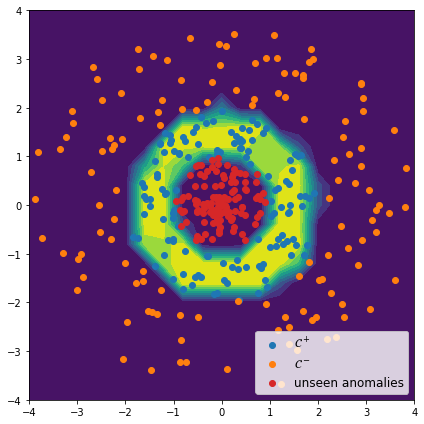

In [23]:
plt.figure(figsize=(6, 6))
plt.contourf(xs, xs, F.reshape(xs.shape[0], xs.shape[0]), cmap=plt.cm.viridis, levels=np.linspace(0, 1, num=11))
# plt.colorbar()

plt.scatter(data_pos[:, 0], data_pos[:, 1], color=plt.cm.tab10(0), label='$\mathcal{C}^+$')
plt.scatter(data_neg[:, 0], data_neg[:, 1], color=plt.cm.tab10(1), label='$\mathcal{C}^-$')
plt.scatter(data_test[:, 0], data_test[:, 1], color=plt.cm.tab10(3), label='unseen anomalies')
plt.legend(fontsize=12, loc='lower right')

plt.tight_layout()
plt.savefig('imgs/metric-learning-ope.png', dpi=200)

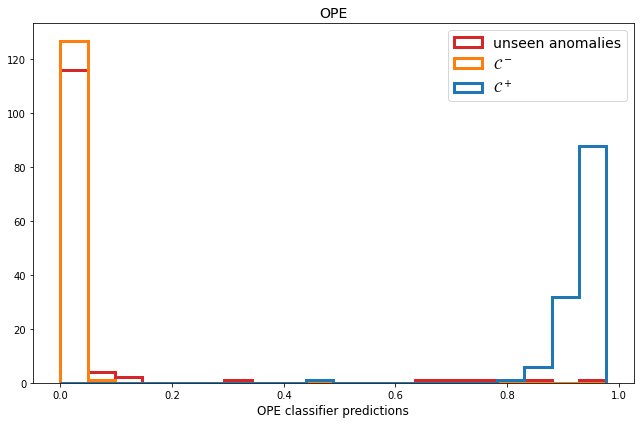

In [24]:
p_pos = tf.sigmoid(clf(data_pos))
p_neg = tf.sigmoid(clf(data_neg))
p_test = tf.sigmoid(clf(data_test))

plt.figure(figsize=(9, 6))
_ = plt.hist(
    [p_pos, p_neg, p_test],
    histtype='step', bins=20, lw=3,
    label=['$\mathcal{C}^+$', '$\mathcal{C}^-$', 'unseen anomalies'],
    color=[plt.cm.tab10(0), plt.cm.tab10(1), plt.cm.tab10(3)],
)
_ = plt.legend(loc='upper right', fontsize=14)
plt.xlabel('OPE classifier predictions', fontsize=12)
plt.title('OPE', fontsize=14)

plt.tight_layout()
plt.savefig('imgs/metric-learning-OPE-predictions.png', dpi=200)